# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
import os
%matplotlib inline

## Image Preprocessing

### Camera Calibration using chessboard images

#### Define the calibration function
* find corners
* draw corners
* output object points and image points as file

In [4]:
dir_source="camera_cal"
dir_desti="output_images"
dir_test = "test_images"

In [5]:
def camera_calibration(nx=9, ny=6, dir_source="camera_cal", dir_desti="output_images"):
    
    # prepare object points
    nx = nx # the number of inside corners in x
    ny = ny # the number of inside corners in y
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(dir_source+'/'+'calibration*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
#         plt.imshow(img)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            write_name = dir_desti+'/'+'corners_found'+str(idx+1)+'.jpg'
            cv2.imwrite(write_name, img)
#             plt.imshow(img)
#             cv2.waitKey(500)

#     cv2.destroyAllWindows()
    fullpath = dir_source+'/'+'calibration3.jpg'
    img = cv2.imread(fullpath)
    img_size = (img.shape[1], img.shape[0])
    
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)

    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    aim_file = open(dir_source+"/wide_dist_pickle.p", "wb")
    pickle.dump( dist_pickle, aim_file)
    aim_file.close()

        #dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    

In [6]:
# Conduct calibration process
def test_camera_calibration():
    camera_calibration()

#### Define function for distortion process
* read in the save obj and img points
* process undistortion
* visualization the results
* save the results in files

In [7]:
def undistortion_conduct(dir_source="camera_cal", dir_desti="output_images"):
    # Step through the list and search for chessboard corners
    pickle_file = open('camera_cal/wide_dist_pickle.p', 'rb')
    dist_pickle=pickle.load(pickle_file)
    pickle_file.close()
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    if dir_source == "camera_cal":
        images = glob.glob(dir_source+'/'+'calibration*.jpg')
        for idx, fname in enumerate(images):
            img = cv2.imread(fname)
            dst = cv2.undistort(img, mtx, dist, None, mtx)
            cv2.imwrite(dir_desti+'/'+'unstored'+str(idx+1)+'_undistort.jpg',dst)
            # Visualize undistortion comparison
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
            ax1.imshow(img)
            ax1.set_title('Original Image', fontsize=30)
            ax2.imshow(dst)
            ax2.set_title('Undistorted Image', fontsize=30)
            plt.savefig(dir_desti+'/'+fname[-16:-4]+'_compar_ori_undist.jpg')
    else:
        img = cv2.imread(dir_source)
#         plt.imshow(img)
        dst = cv2.undistort(img, mtx, dist, None, mtx)
        cv2.imwrite(dir_desti+'/'+dir_source[-9:-4]+'_undistort.jpg',dst)
        # Visualize undistortion comparison
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=30)
        ax2.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted Image', fontsize=30)
        plt.savefig(dir_desti+'/'+dir_source[-9:-4]+'_compar_ori_undist.jpg')

In [8]:
# Conduct undistortion process on all images
def test_undistortion_conduct_chess():
    undistortion_conduct()

In [9]:
def test_undistortion_conduct_real_pic():
    undistortion_conduct(dir_source=dir_test+'/straight_lines2.jpg')


### Use Threshhold to Creat Binary Image

#### Investigate different color channels

#### Investigate the different sobel applicaion

In [10]:
# absolute gradient
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh_min=20, thresh_max=100):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        print("the inputed orient is not valid")
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel>=thresh_min)&(scaled_sobel<=thresh_max)]=1
    # 6) Return this mask as your binary_output image
    return sxbinary

# direction of the gradient and applies a threshold.
def dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    sobelx_abs = np.absolute(sobelx)
    sobely_abs = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dire_gradient = np.arctan2(sobely_abs, sobelx_abs)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(dire_gradient)
    binary_output[(dire_gradient >= thresh[0]) & \
                    (dire_gradient <= thresh[1])] = 1
    # 6) Return this mask as the binary_output image
    return binary_output

# Magnitude of the gradient
def mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output



#### Test the Absolute Sobel threshhold

In [11]:
def test_abs_sobel_thresh_x():
    # Test for x
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements
    # Choose a image

    image = mpimg.imread('test_images/test5_undistort.jpg')

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh_min=15, thresh_max=90)
    # 20, 100

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(gradx, cmap='gray')
    ax2.set_title('Thresholded Grad. abs_x', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [12]:
def test_abs_sobel_thresh_y():
    # Test for y
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements
    # Choose a image

    image = mpimg.imread('test_images/test5_undistort.jpg')

    # Apply each of the thresholding functions
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh_min=20, thresh_max=100)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(grady, cmap='gray')
    ax2.set_title('Thresholded Grad. abs_y', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Test the Magnitude Sobel threshhold

In [13]:
def test_mag_thresh():
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements
    # Choose a image

    image = mpimg.imread('test_images/test5_undistort.jpg')

    # Apply each of the thresholding functions
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    # 30, 100
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(combined, cmap='gray')
    ax2.set_title('Thresholded Grad. Magni.', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Test the direction Sobel threshhold

In [14]:
def test_dir_threshold():
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements
    # Choose a image

    image = mpimg.imread('test_images/test5_undistort.jpg')

    # Apply each of the thresholding functions
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))    # 0.7, 1.3

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(dir_binary, cmap='gray')
    ax2.set_title('Thresholded Grad. Dire.', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Test the combined Sobel threshhold

In [15]:
def test_combined_thresh_complex():
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements
    # Choose a image

    image = mpimg.imread('test_images/test5_undistort.jpg')

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh_min=20, thresh_max=100)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh_min=20, thresh_max=100)
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))   # 30, 100
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))    # 0.7, 1.3

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(combined, cmap='gray')
    ax2.set_title('Thresholded Grad. Combi1.', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [16]:
def test_combined_thresh_simple():
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements
    # Choose a image

    image = mpimg.imread('test_images/test5_undistort.jpg')

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh_min=20, thresh_max=100)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh_min=20, thresh_max=100)
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))   # 30, 100
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))    # 0.7, 1.3

    combined = np.zeros_like(dir_binary)
    # combined[((gradx == 1) & (dir_binary == 1)) | ((grady == 1) & (mag_binary == 1) )] = 1
    combined[((gradx == 1) & (dir_binary == 1))] = 1
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(combined, cmap='gray')
    ax2.set_title('Thresholded Grad. Combi2.', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Color Threthhold Implementation

Firstly we glimpse the different channel in grey scale.

In [17]:
def investigation_color_channels():
    # Investigate the channel overview
    img_cbi = mpimg.imread('test_images/test5.jpg')
    img_cbi_r = img_cbi[:,:,0]
    img_cbi_g = img_cbi[:,:,1]
    img_cbi_b = img_cbi[:,:,2]

    img_cbi_hls = cv2.cvtColor(img_cbi, cv2.COLOR_RGB2HLS)
    img_cbi_h = img_cbi_hls[:,:,0]
    img_cbi_l = img_cbi_hls[:,:,1]
    img_cbi_s = img_cbi_hls[:,:,2]

    fig0 = plt.figure()
    ax0 = fig0.add_subplot(1, 1, 1)
    ax0.imshow(img_cbi)
    ax0.set_title('original image')

    fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    fig1.tight_layout()
    ax1.imshow(img_cbi_r, cmap='gray')
    ax1.set_title('R Channel')
    ax2.imshow(img_cbi_g, cmap='gray')
    ax2.set_title('G Channel')
    ax3.imshow(img_cbi_b, cmap='gray')
    ax3.set_title('B Channel')
    plt.savefig(dir_desti+'/'+'compareRGB.jpg')

    fig2, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize=(24, 9))
    fig2.tight_layout()
    ax4.imshow(img_cbi_h, cmap='gray')
    ax4.set_title('H Channel')
    ax5.imshow(img_cbi_l, cmap='gray')
    ax5.set_title('L Channel')
    ax6.imshow(img_cbi_s, cmap='gray')
    ax6.set_title('S Channel')
    plt.savefig(dir_desti+'/'+'compareHLS.jpg')


With the observation of the different color channel, R, B, G.
And the investigation of H, L, S, we can find the line color is distinct in R channel and S aspect.

secondly, we apply threshhold for the seperate channel.
So we gain more knowledge about the performance.

In [18]:
# Define function for processing HLS threshhold and output a binary img
def hls_select(img, thresh=(160, 255), channel='s'):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the one channel
    if channel=='h':
        hls_one = hls[:,:,0]
    elif channel=='l':
        hls_one = hls[:,:,1]
    else:
        hls_one = hls[:,:,2]
    binary_output = np.zeros_like(hls_one)
    binary_output[(hls_one>thresh[0])&(hls_one<=thresh[1])]=1
    # 3) Return a binary image of threshold result
    return binary_output

In [19]:
def test_hls_select():
    # Test the hls_select function
    image = mpimg.imread('test_images/test5.jpg') 
    hls_binary = hls_select(image, thresh=(160, 255), channel='s')
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(hls_binary, cmap='gray')
    ax2.set_title('Thresholded S', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [20]:
# Define function for processing RGB threshhold and output a binary img
def rgb_select(img, thresh=(160, 255), channel='r'):
    # 1) Apply a threshold to the one channel
    if channel=='b':
        rgb_one = img[:,:,2]
    elif channel=='g':
        rgb_one = img[:,:,1]
    else:
        rgb_one = img[:,:,0]
    binary_output = np.zeros_like(rgb_one)
    binary_output[(rgb_one>thresh[0])&(rgb_one<=thresh[1])]=1
    # 2) Return a binary image of threshold result
    return binary_output

In [21]:
# Test the rgb_select function
def test_rgb_select():
    image = mpimg.imread('test_images/test5.jpg') 
    rgb_binary = rgb_select(image, thresh=(210, 255), channel='r')
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(rgb_binary, cmap='gray')
    ax2.set_title('Thresholded R', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

**Conclustion:**
Thought the detailed investigation. We confirmed that the Threathhold in S and R channel can distinguish the lane line in the near field. And threshold of absolute gradient in x give a presentation of lane line in the far field.

Then we combine the Threathhold in S and gradien x for the further investigation.

In [22]:
def test_combined_gradx_s():
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements
    # Choose a image

    image = mpimg.imread('test_images/test5_undistort.jpg')

    # Apply the thresholding functions in grad X
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh_min=20, thresh_max=100)
    hls_binary = hls_select(image, thresh=(160, 255), channel='s')

    combined_gradx_s = np.zeros_like(gradx)
    combined_gradx_s[((gradx == 1) | (hls_binary == 1))] = 1
#     print(combined_gradx_s.shape)
#     print(combined_gradx_s)

    # Plot the result

    # fig0 = plt.figure()
    # ax0 = fig0.add_subplot(1, 1, 1)
    cv2.imwrite('test_images/test5_threshold.jpg',combined_gradx_s*255)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(combined_gradx_s, cmap='gray')
    ax2.set_title('Thresholded Grad. Combi. GradX + S', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [23]:
# test_combined_gradx_s()

### Perspective Transform

In [24]:
# Function for perspective Transform
# def thresh_warp(undist, nx, ny, mtx, dist):
def thresh_warp(undist):
    global Minv
    img_size = (undist.shape[1], undist.shape[0])
    src = np.float32(
        [[(img_size[0] / 2) - 63, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 20), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 65), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])

    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size, flags= cv2.INTER_LINEAR) 
    Minv = cv2.getPerspectiveTransform(dst, src)

    return warped, M

In [25]:
# test the thresh_warp function
def test_thresh_warp():
    img = cv2.imread('test_images/test5_threshold.jpg')
    nx = 9 # the number of inside corners in x
    ny = 6 # the number of inside corners in y

    #read the pickle file
    picklefile = open(dir_source+"/wide_dist_pickle.p", "rb")
    dist_pickle = pickle.load(picklefile)
    picklefile.close()
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

    top_down, perspective_M = thresh_warp(img, nx, ny, mtx, dist)
#     print(top_down.shape)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(top_down)
    ax2.set_title('Undistorted and Warped Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    cv2.imwrite('test_images/test5_pers_trans.jpg',top_down)

In [26]:
# test_thresh_warp()

## Lane Searching

### Polynomial fit according to the pixels

In [27]:
def find_lane_pixels(thresh):
    # Take a histogram of the bottom half of the image
    if len(thresh.shape)>2:
        binary_warped = cv2.cvtColor(thresh, cv2.COLOR_RGB2GRAY)
    else:
        binary_warped = thresh
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
                      (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
                      (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    return left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty

In [28]:
def test_fit_polynomial_find_lane_pixels():
    # Test the function fit_polynomial, find_lane_pixels
    thresh = mpimg.imread('test_images/test5_pers_trans.jpg')
    left_fitx, right_fitx, ploty = fit_polynomial(thresh)
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.imshow(out_img)
    # plt.savefig('test_images/test5_draw_rechtangle.jpg')

In [29]:
# test_fit_polynomial_find_lane_pixels()

#### Calculation of the curvature

In [30]:
def measure_curvature_offset(thresh, leftx, lefty, rightx, righty):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(thresh.shape[0]*ym_per_pix//2)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Calculation of offset
    y_eval_near = np.max((thresh.shape[0]-1)*ym_per_pix)
    left_near_lane = np.poly1d(left_fit)(y_eval_near)
    right_near_lane = np.poly1d(right_fit)(y_eval_near)

    lane_centor = (left_near_lane + right_near_lane) / 2
    image_centor = (thresh.shape[1]-1) * xm_per_pix / 2

    offset = lane_centor - image_centor
    
    return left_curverad, right_curverad, offset

In [31]:
# Test the function measure_curvature_pixels
# TODO why measure_curvature_offset takes 0 argument
def test_measure_curvature_offset():
    thresh = mpimg.imread('test_images/test5_pers_trans.jpg')
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(thresh)
    # Calculate the radius of curvature in pixels for both lane lines
#     left_curverad, right_curverad, offset = measure_curvature_offset(thresh, leftx, lefty, rightx, righty)
    left_curverad, right_curverad, offset = measure_curvature_offset(thresh, leftx, lefty, rightx, righty)
    print(left_curverad, 'm', right_curverad, 'm', offset, 'm')

In [32]:
# test_measure_curvature_offset()

## Video Generation

In [33]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [34]:
def put_lane_info_on_video(image, left_curverad, right_curverad, offset):
    """project the fited lane information to the image
    use last 15 frame average data to avoid the number quick jump on screen.
    """
    color=(0,200,255)
    offset = float(format(offset, '.3f'))
    curverad = format(left_curverad, '.3f')
    left_right = "right" if offset < 0 else "left"
    info_curv = "Curve Radius is {}(m)".format(curverad)
    info_offs = "Offset is {0:.2f}m ".format(abs(offset)) + "{} of the center".format(left_right)
    cv2.putText(image, info_curv, (50,60), cv2.FONT_HERSHEY_SIMPLEX,2,color,2)
    cv2.putText(image, info_offs, (50,120), cv2.FONT_HERSHEY_SIMPLEX,2,color,2)
    return image

- how to put words on the video
- how to use the line class
- how to find the line and arean
- how to draw line and area on the video


In [35]:
def drawing_area(birdeye_thresh_warped, ori_image, left_fitx, right_fitx, ploty):
    
#     ori_image = ori_image = mpimg.imread(image) # changed for video
    
    # Create an image to draw the lines on
#     warp_zero = np.zeros((720,1280)).astype(np.uint8)
    warp_zero = np.zeros_like(birdeye_thresh_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (ori_image.shape[1], ori_image.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(ori_image, 1, newwarp, 0.3, 0)
    return result

In [36]:
# # test drawing and output the result on img
# thresh = mpimg.imread('test_images/test5_pers_trans.jpg')
    
# ori_image = mpimg.imread('test_images/test5.jpg')
# left_fitx, right_fitx, ploty = fit_polynomial(thresh)
    
# warp_zero = np.zeros((720,1280)).astype(np.uint8)
# color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

#     # Recast the x and y points into usable format for cv2.fillPoly()
# pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
# pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
# pts = np.hstack((pts_left, pts_right))

#     # Draw the lane onto the warped blank image
# cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

#     # Warp the blank back to original image space using inverse perspective matrix (Minv)
# newwarp = cv2.warpPerspective(color_warp, Minv, (ori_image.shape[1], ori_image.shape[0])) 
#     # Combine the result with the original image
# result = cv2.addWeighted(ori_image, 1, newwarp, 0.3, 0)
# color=(0,200,255)
# cv2.putText(result, ' 1000', (50,60), cv2.FONT_HERSHEY_SIMPLEX,2,color,2)
# plt.imshow(result)
# # plt.savefig('test_images/test5_lane_area_draw.jpg')

## Pipeline

In [37]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line

In [38]:
def undistortion_conduct2(img):
    # Step through the list and search for chessboard corners
#     img = cv2.imread(ori_image) # changed for video
    undistort = cv2.undistort(img, mtx, dist, None, mtx)
    return undistort

In [39]:
def combined_gradx_s(image, ksize = 3):
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh_min=20, thresh_max=100)
    hls_binary = hls_select(image, thresh=(160, 255), channel='s')
    combined_gradx_s = np.zeros_like(gradx)
    combined_gradx_s[((gradx == 1) | (hls_binary == 1))] = 1
    return combined_gradx_s

In [40]:
def finding_lanes_pipeline(ori_image):
    global mtx, dist
    # Make the data ready, which is used for the transformation
    pickle_file = open('camera_cal/wide_dist_pickle.p', 'rb')
    dist_pickle=pickle.load(pickle_file)
    pickle_file.close()
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    # transform the distorted image
    undistort = undistortion_conduct2(ori_image)
    # use gradient methode
    thresh = combined_gradx_s(undistort, ksize = 3)
    # perspective transform 
#     birdeye_thresh_warped, perspective_M = thresh_warp(thresh, 9, 6, mtx, dist)
    birdeye_thresh_warped, perspective_M = thresh_warp(thresh)
    # generate polynomial based on the pixels
    left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty = fit_polynomial(birdeye_thresh_warped)
    left_curverad, right_curverad, offset = measure_curvature_offset(birdeye_thresh_warped, leftx, lefty, rightx, righty)
    drawed = drawing_area(birdeye_thresh_warped, ori_image, left_fitx, right_fitx, ploty)
    put_lane_info_on_video(drawed, left_curverad, right_curverad, offset)
    return drawed

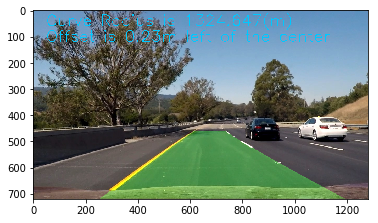

In [44]:
plt.imshow(finding_lanes_pipeline(mpimg.imread('test_images/test6.jpg')))

## Test on Video and Generate result

In [42]:
# # # for project_video.mp4
# # white_output = 'test_videos_output/project_video.mp4'
# # clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
# # # clip1 = VideoFileClip("project_video.mp4")

# # for challenge_video.mp4
# white_output = 'test_videos_output/challenge_video.mp4'
# # clip1 = VideoFileClip("challenge_video.mp4").subclip(0,5)
# clip1 = VideoFileClip("challenge_video.mp4")

# white_clip = clip1.fl_image(finding_lanes_pipeline)
# %time white_clip.write_videofile(white_output, audio=False)

In [43]:
# HTML("""
# <video width="960" height="540" controls>
#   <source src="{0}">
# </video>
# """.format(white_output))